In [1]:
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

In [2]:
 #get the IPBES sub regions
# Read the shapefile

shp_dir = "/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/IPBES_Regions_Subregions2.shp"
shp = gpd.read_file(shp_dir)

# Define the region mapping
region_mapping = {
    'Carribean': 'Caribbean & Mesoamerica',
    'Central Africa': 'West, Central, East & South Africa',
    'Central and Western Europe': 'Central and Western Europe',
    'Central Asia': 'Central, North-East & South Asia',
    'East Africa and adjacent islands': 'West, Central, East & South Africa',
    'Eastern Europe': 'Eastern Europe',
    'Mesoamerica': 'Caribbean & Mesoamerica',
    'North Africa': 'North Africa & Western Asia',
    'North America': 'North America',
    'Nort-East Asia': 'Central, North-East & South Asia',
    'Oceania': 'Oceania',
    'South America': 'South America',
    'South Asia': 'Central, North-East & South Asia',
    'South-East Asia': 'South-East Asia',
    'Southern Africa': 'West, Central, East & South Africa',
    'West Africa': 'West, Central, East & South Africa',
    'Western Asia': 'North Africa & Western Asia'
}

# Create the new_region column in the shapefile
shp['new_region'] = shp['Sub_Region'].map(region_mapping)


#

In [3]:

import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['Central, North-East & South Asia','West, Central, East & South Africa', 'Central and Western Europe','North Africa & Western Asia', 'South America','Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America'             ]
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["cropland","pasture","forest","natural_land"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


mean_newvalue_hist= {}
mean_newvalue_fut = {}
mean_sumbin_hist = {}
mean_sumbin_fut = {}
    
mean_over_sdms_gcms_hist = {}
mean_over_sdms_gcms_fut = {}
mean_over_sdms_gcms_sumbin_hist = {}
mean_over_sdms_gcms_sumbin_fut = {}

mean_over_all_sdms_gcms_hist = {}
mean_over_all_sdms_gcms_fut = {}
mean_over_all_sdms_gcms_sumbin_hist = {}
mean_over_all_sdms_gcms_sumbin_fut = {}


for scenario in scenarios:

    mean_over_sdms_gcms_hist[scenario] = {}
    mean_over_sdms_gcms_fut[scenario] = {}
    mean_over_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_over_all_sdms_gcms_hist[scenario] = {}
    mean_over_all_sdms_gcms_fut[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_newvalue_hist[scenario] = {}
    mean_newvalue_fut[scenario] = {}
    mean_sumbin_hist[scenario] = {}
    mean_sumbin_fut[scenario] = {}
    
    dataarrays_sdms_newvalue_hist = []
    dataarrays_sdms_newvalue_fut = []
    dataarrays_sdms_sumbin_hist = []
    dataarrays_sdms_sumbin_fut = []

    for habitat in habitats:

        # Initialize taxa-level lists
        dataarrays_sdms_newvalue_hist = []
        dataarrays_sdms_newvalue_fut = []
        dataarrays_sdms_sumbin_hist = []
        dataarrays_sdms_sumbin_fut = []
        
        mean_over_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_over_all_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_newvalue_hist[scenario][habitat] = {}
        mean_newvalue_fut[scenario][habitat] = {}
        mean_sumbin_hist[scenario][habitat] = {}
        mean_sumbin_fut[scenario][habitat] = {}

        for sdm in sdms:

            mean_newvalue_hist[scenario][habitat][sdm] = {}
            mean_newvalue_fut[scenario][habitat][sdm] = {}
            mean_sumbin_hist[scenario][habitat][sdm] = {}
            mean_sumbin_fut[scenario][habitat][sdm] = {}

            dataarrays_newvalue_hist = []
            dataarrays_newvalue_fut = []
            dataarrays_sumbin_hist = []
            dataarrays_sumbin_fut = []


            for gcm in gcms:
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = {}
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = {}

                sum_newvalue_hist = None
                sum_newvalue_future = None
                sum_sumbin_hist = None
                sum_sumbin_future = None

                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_taxa = pickle.load(f)
                    
                weights_newvalue = np.cos(np.deg2rad(newvalue_hist_taxa.lat))
                weights_newvalue.name = "weights"

                    
                # Assign the summed values to your dictionary
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = newvalue_hist_taxa
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = newvalue_future_taxa
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = sum_bin_hist_taxa
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = sum_bin_future_taxa

                dataarrays_newvalue_hist.append(mean_newvalue_hist[scenario][habitat][sdm][gcm])
                dataarrays_newvalue_fut.append(mean_newvalue_fut[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_hist.append(mean_sumbin_hist[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_fut.append(mean_sumbin_fut[scenario][habitat][sdm][gcm])
                

            # Concatenate and calculate the mean over the new dimension
            mean_over_sdms_gcms_hist[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_fut[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')

                   # Append the mean DataArrays across GCMs to the SDM lists
            dataarrays_sdms_newvalue_hist.append(mean_over_sdms_gcms_hist[scenario][habitat][sdm])
            dataarrays_sdms_newvalue_fut.append(mean_over_sdms_gcms_fut[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_hist.append(mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_fut.append(mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm])

        # Concatenate and calculate the mean over SDMs
        mean_over_all_sdms_gcms_hist[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_fut[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm') 

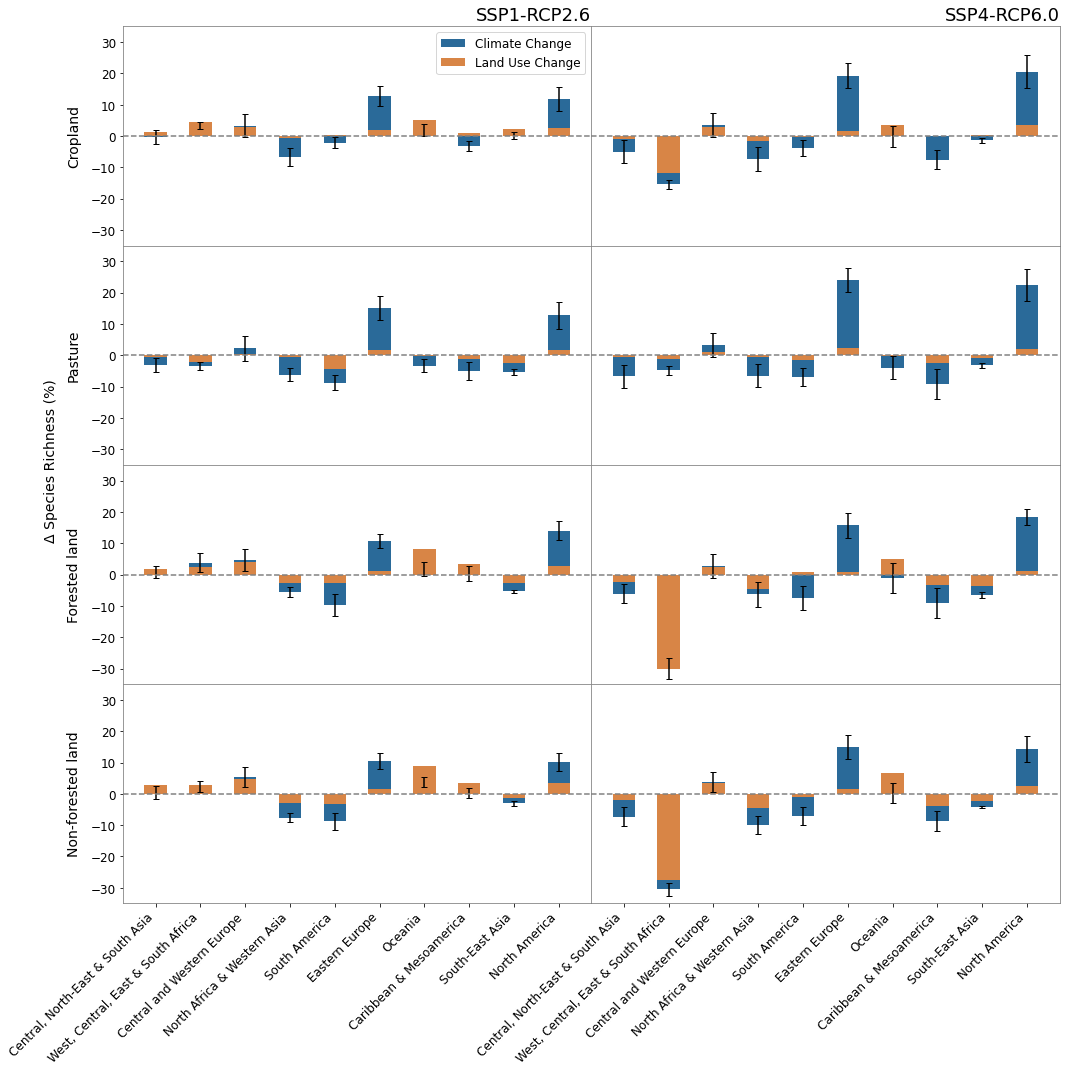

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
def set_plot_param():
    """Set my own customized plotting parameters"""
    mpl.rc('axes', edgecolor='grey')
    mpl.rc('axes', labelcolor='black')
    mpl.rc('xtick', color='black')
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', color='black')
    mpl.rc('ytick', labelsize=12)
    mpl.rc('axes', titlesize=18)
    mpl.rc('axes', labelsize=12)
    mpl.rc('legend', fontsize='large')
    mpl.rc('text', color='black')

# Call the function to set the plot parameters
set_plot_param()
# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.5 # the width of the bars
        ax.bar(x , rel_diff_newvalue_means,  width, bottom=rel_diff_sumbins,  label='Climate Change', color="#2a6a99")
        ax.bar(x , rel_diff_sumbins, width, label='Land Use Change', color="#d88546")

        # Adding error bars
        ax.errorbar(x,total_heights, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right')
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend()

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=14)
fig.text(0.05, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=14)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed
#plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Figure_3")
# Show the plot
plt.show()

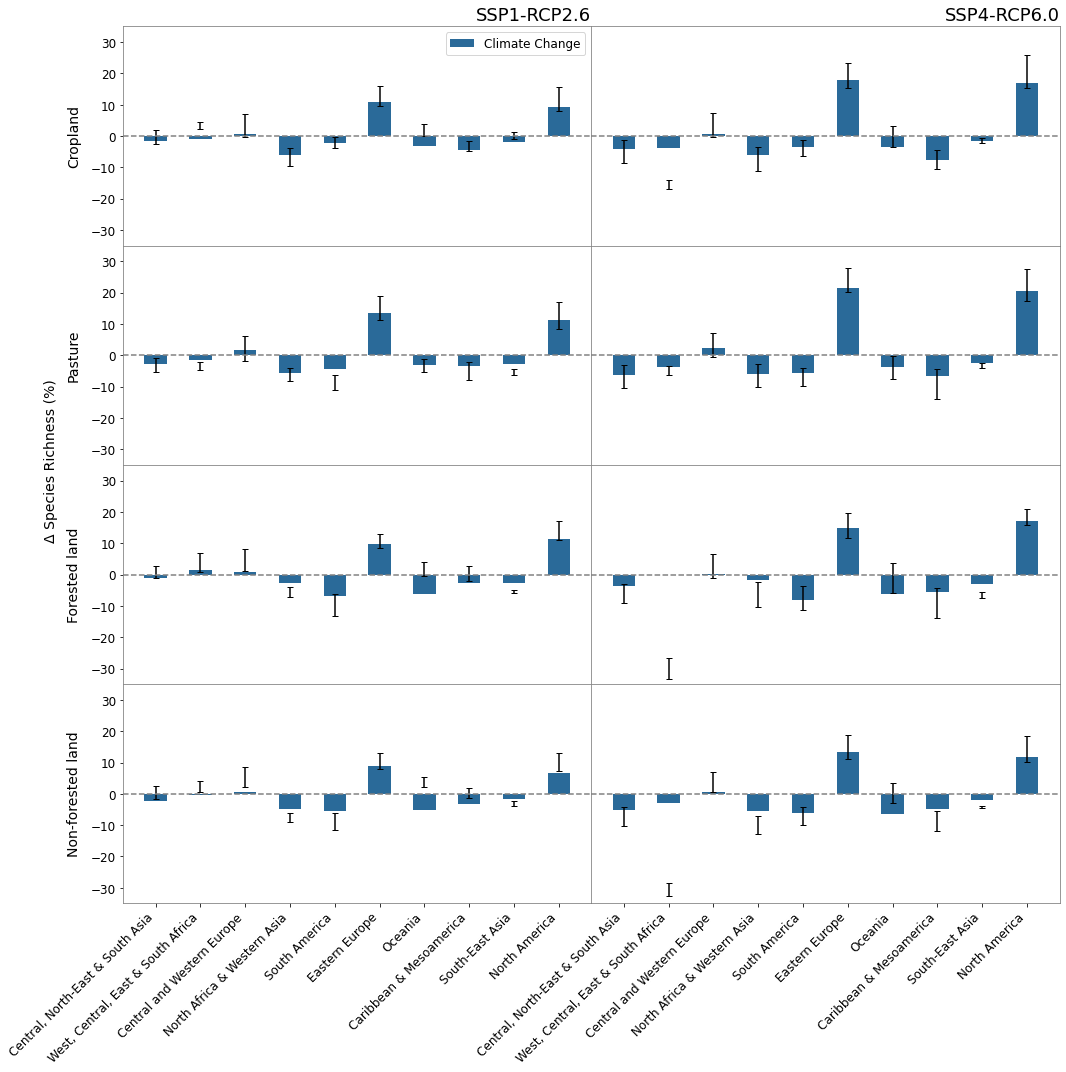

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
def set_plot_param():
    """Set my own customized plotting parameters"""
    mpl.rc('axes', edgecolor='grey')
    mpl.rc('axes', labelcolor='black')
    mpl.rc('xtick', color='black')
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', color='black')
    mpl.rc('ytick', labelsize=12)
    mpl.rc('axes', titlesize=18)
    mpl.rc('axes', labelsize=12)
    mpl.rc('legend', fontsize='large')
    mpl.rc('text', color='black')

# Call the function to set the plot parameters
set_plot_param()
# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.5 # the width of the bars
        ax.bar(x , rel_diff_newvalue_means, width,  label='Climate Change', color="#2a6a99")
      

        # Adding error total_heights
        ax.errorbar(x,total_heights, yerr=std_dev_newvalue,  fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right')
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend()

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=14)
fig.text(0.05, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=14)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed

plt.show()

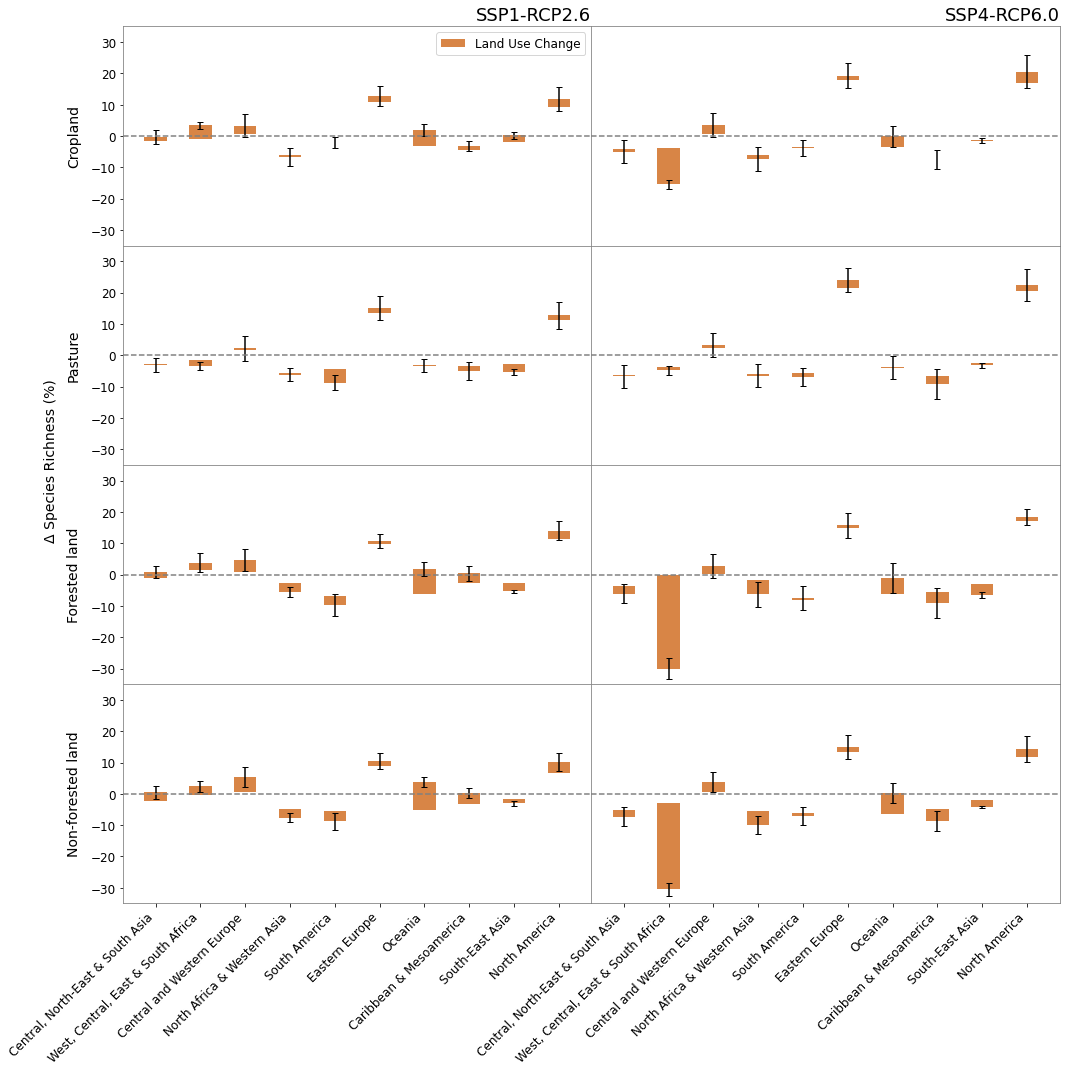

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
def set_plot_param():
    """Set my own customized plotting parameters"""
    mpl.rc('axes', edgecolor='grey')
    mpl.rc('axes', labelcolor='black')
    mpl.rc('xtick', color='black')
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', color='black')
    mpl.rc('ytick', labelsize=12)
    mpl.rc('axes', titlesize=18)
    mpl.rc('axes', labelsize=12)
    mpl.rc('legend', fontsize='large')
    mpl.rc('text', color='black')

# Call the function to set the plot parameters
set_plot_param()
# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.5 # the width of the bars
        ax.bar(x , rel_diff_sumbins, width, rel_diff_newvalue_means,  label='Land Use Change', color="#d88546")
      

        # Adding error bars
        ax.errorbar(x,total_heights, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right')
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend()

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=14)
fig.text(0.05, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=14)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed

plt.show()

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'forested land', "natural_land": 'non-forested land',"cropland": 'cropland',"pasture": 'pasture'}


# Initialize an empty DataFrame
data = []


# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)
        ax.set_ylim([-35, 35])
        for k, region in enumerate(regionlist):
            row = {
                'Region': region,
                'Habitat': habitat_indices[habitat],
                'Scenario': scenario_indices[scenario],
                'Mean Relative Difference': round(float(rel_diff_newvalue_means[k]),3),
                'Mean Land Use Change': round(float(rel_diff_sumbins[k]),3),
                'Standard Deviation': round(std_dev_newvalue[k],3)
            }
            data.append(row)

# Create the DataFrame from the accumulated data
df = pd.DataFrame(data)

# Set the index of the DataFrame to the region names if desired
df.set_index('Region', inplace=True)

# Display the DataFrame
print(df)

                                              Habitat     Scenario  \
Region                                                               
West, Central, East & South Africa           cropland  SSP1-RCP2.6   
Central and Western Europe                   cropland  SSP1-RCP2.6   
North Africa & Western Asia                  cropland  SSP1-RCP2.6   
South America                                cropland  SSP1-RCP2.6   
Eastern Europe                               cropland  SSP1-RCP2.6   
...                                               ...          ...   
Oceania                             non-forested land  SSP4-RCP6.0   
Caribbean & Mesoamerica             non-forested land  SSP4-RCP6.0   
South-East Asia                     non-forested land  SSP4-RCP6.0   
North America                       non-forested land  SSP4-RCP6.0   
Central, North-East & South Asia    non-forested land  SSP4-RCP6.0   

                                    Mean Relative Difference  \
Region                   

In [12]:
df.to_csv("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/output_fig3.csv", index=True)

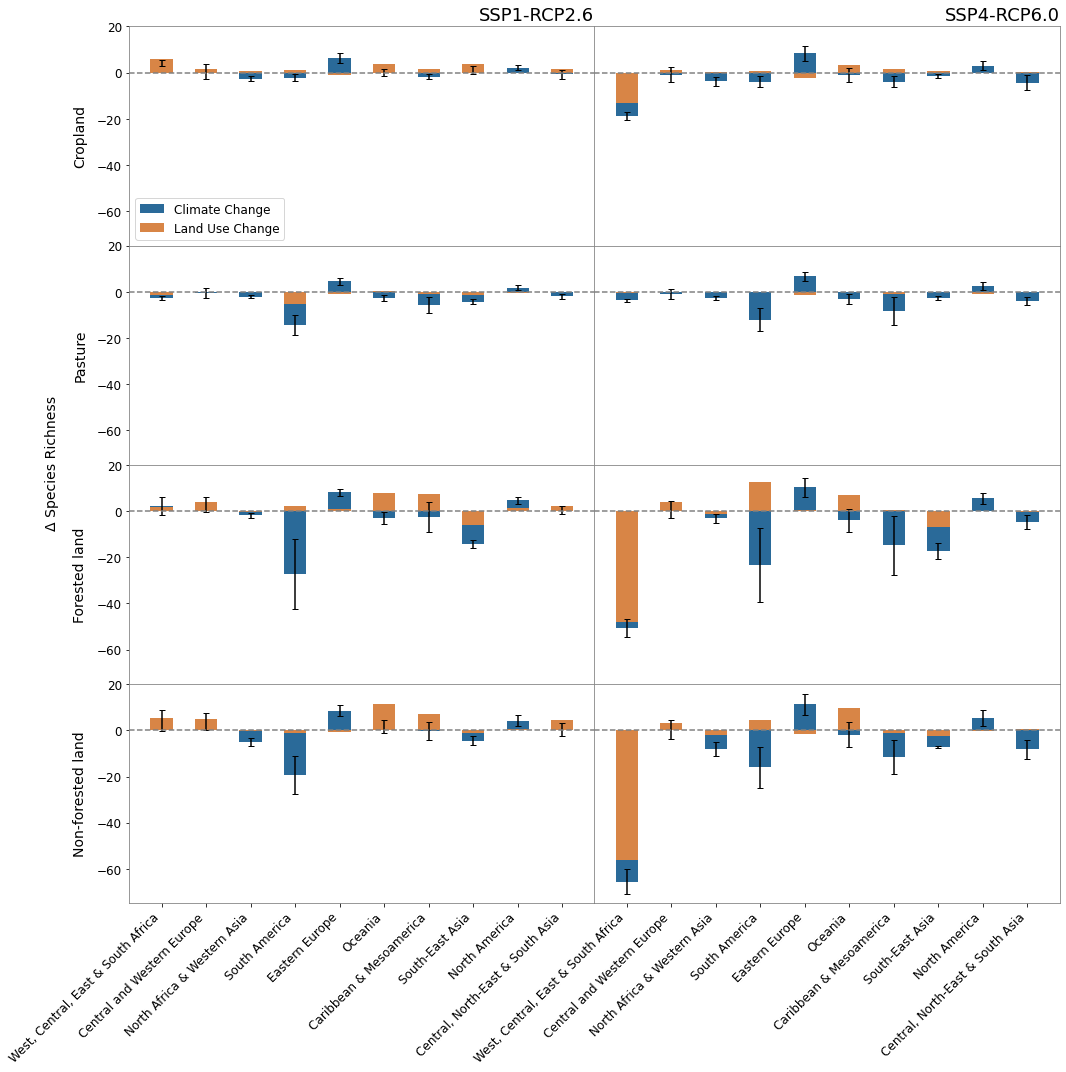

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
def set_plot_param():
    """Set my own customized plotting parameters"""
    mpl.rc('axes', edgecolor='grey')
    mpl.rc('axes', labelcolor='black')
    mpl.rc('xtick', color='black')
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', color='black')
    mpl.rc('ytick', labelsize=12)
    mpl.rc('axes', titlesize=18)
    mpl.rc('axes', labelsize=12)
    mpl.rc('legend', fontsize='large')
    mpl.rc('text', color='black')

# Call the function to set the plot parameters
set_plot_param()
# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0

            difference = (newvalue_future - newvalue_hist)


            climate_change = difference.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            difference = (sumbin_future - sumbin_hist) 


            climate_land_change = difference.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    difference = sep_future - sep_hist
                    # Calculate the mean for this SDM and GCM
                    relative_change = difference.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)
        ax.set_ylim([-75, 20])
        # Plotting the bars
        width = 0.5 # the width of the bars
        ax.bar(x , rel_diff_newvalue_means, width, bottom=rel_diff_sumbins, label='Climate Change', color="#2a6a99")
        ax.bar(x , rel_diff_sumbins, width, label='Land Use Change', color="#d88546")

        # Adding error bars
        ax.errorbar(x, total_heights, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        #ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right')
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend()

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=14)
fig.text(0.05, 0.57, 'Δ Species Richness ', va='center', rotation='vertical', fontsize=14)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed

# Show the plot
plt.show()

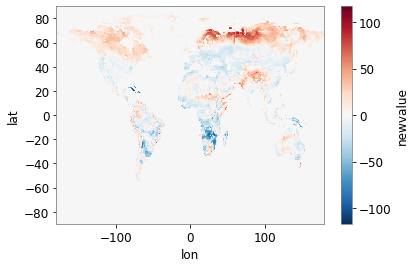

In [28]:
difference.plot()